In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import optimize
from astropy.io import fits
%matplotlib inline

import warnings
warnings.simplefilter('ignore', np.RankWarning)

In [2]:
fits.info("Out_Polaris_ExtCorr.fits")
fits.info("GamCass3_NoE.fits")

Filename: Out_Polaris_ExtCorr.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     101   (57282,)   float32   
Filename: GamCass3_NoE.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      97   (61333,)   float32   


In [2]:
Ycass_info = fits.getheader("GamCass3_NoE.fits")
Polaris_info = fits.getheader("Out_Polaris_ExtCorr.fits")

In [3]:
print(Ycass_info["CRVAL1"])

4554.17358806


In [3]:
Ystart=Ycass_info["CRVAL1"]
Yend=Ycass_info["CRVAL1"]+Ycass_info["CDELT1"]*Ycass_info["NAXIS1"]

Pstart = Polaris_info["CRVAL1"]
Pend = Polaris_info["CRVAL1"]+Polaris_info["CDELT1"]*Polaris_info["NAXIS1"]

In [4]:
Ycass_ExtCorr = fits.getdata("GamCass3_Ext.fits", ext=0)
Ycass_NoExt = fits.getdata("GamCass3_NoE.fits", ext=0)

Polaris_ExtCorr = fits.getdata("Out_Polaris_ExtCorr.fits", ext=0)
Polaris_NoExt = fits.getdata("Polaris600.fits", ext=0)

In [5]:
x = np.linspace(Ystart, Yend, Ycass_info["NAXIS1"])
xP = np.linspace(Pstart, Pend, Polaris_info["NAXIS1"])

(4500.0, 7500.0)

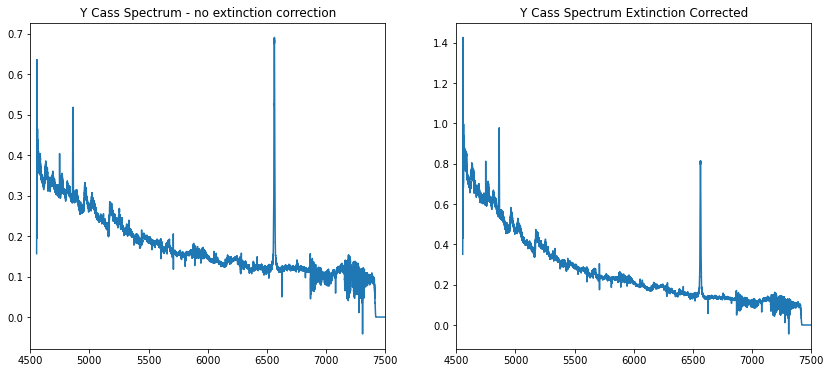

In [6]:
fig = plt.figure(figsize=(14, 6))

ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax.plot(x,Ycass_NoExt)
ax.set_title("Y Cass Spectrum - no extinction correction")
ax.set_xlim([4500,7500])

ax2.plot(x,Ycass_ExtCorr)
ax2.set_title("Y Cass Spectrum Extinction Corrected")
ax2.set_xlim([4500,7500])


(0.0, 0.8)

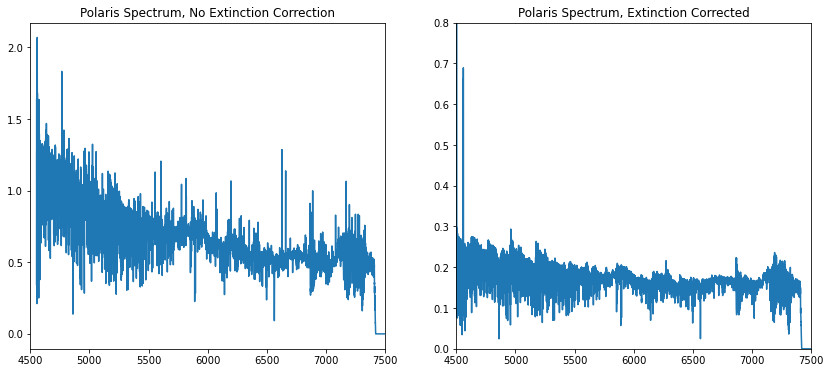

In [7]:
fig = plt.figure(figsize=(14, 6))

ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax.plot(x,Polaris_NoExt)
ax.set_title("Polaris Spectrum, No Extinction Correction")
ax.set_xlim([4500,7500])

ax2.plot(xP,Polaris_ExtCorr)
ax2.set_title("Polaris Spectrum, Extinction Corrected")
ax2.set_xlim([4500,7500])
ax2.set_ylim([0,0.8])


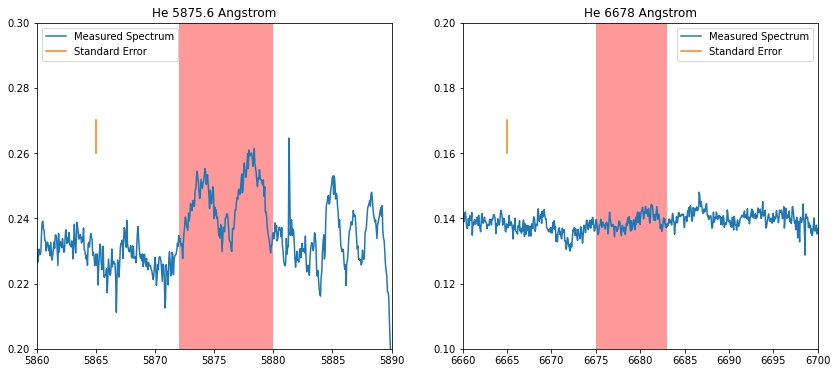

In [26]:
fig = plt.figure(figsize=(14, 6))

ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax.plot(x,Ycass_ExtCorr, label="Measured Spectrum")
ax.set_title("He 5875.6 Angstrom")
ax.plot([5865,5865], [0.26,0.27], label="Standard Error")
ax.axvspan(5872,5880, facecolor='r', alpha=0.4)
ax.set_xlim([5860,5890])
ax.set_ylim([0.2,0.3])
ax.legend()

ax2.plot(x,Ycass_ExtCorr, label="Measured Spectrum")
ax2.set_title("He 6678 Angstrom")
ax2.plot([6665,6665], [0.16,0.17], label="Standard Error")
ax2.axvspan(6675,6683, facecolor='r', alpha=0.4)
ax2.set_xlim([6660,6700])
ax2.set_ylim([0.1,0.2])
ax2.legend()

(0.14, 0.18)

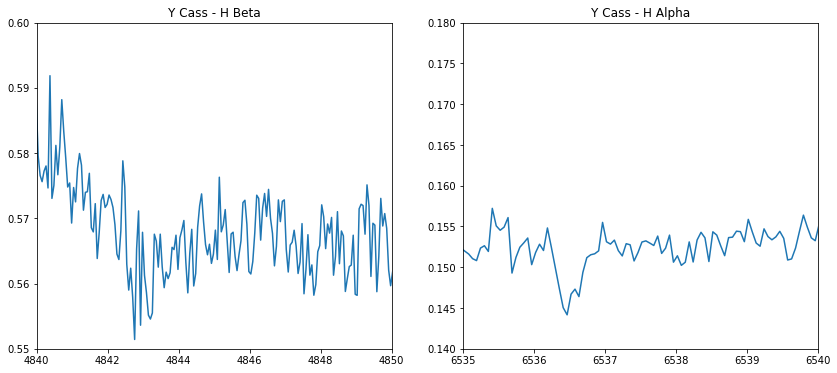

In [7]:
fig = plt.figure(figsize=(14, 6))

ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax.plot(x,Ycass_ExtCorr)
ax.set_title("Y Cass - H Beta")
ax.set_xlim([4840,4850])
ax.set_ylim([0.55,0.6])

ax2.plot(x,Ycass_ExtCorr)
ax2.set_title("Y Cass - H Alpha")
ax2.axvspan(6678,6678.3, facecolor='r')
ax2.set_xlim([6535,6540])
ax2.set_ylim([0.14,0.18])

In [8]:
#Defining the gaussian line profile
def gaussian(x, g_0, g_1, g_2, g_3):
    """Returns gaussian line profile based on g_(0,1,2,3) parameters and given x value
    x
    g0 - Continuum at 1
    g1 - Amplitude of line
    g2 - Location of line
    g3 - Half - width of line
    """

    #Gaussian formula
    return(g_0+g_1*np.exp((-(x-g_2)**2)/(2*g_3**2)))

In [9]:
#Defining the lorentzian line profile
def lorentzian(x, l_0, l_1, l_2, l_3):
    """Returns lorentzian line profile based on l_(0,1,2,3) parameters and given x value
    x
    l0 - Continuum at 1
    l1 - Amplitude of line
    l2 - Location of line
    l3 - Half - width of line
    """

    #Lorentzian formula
    return(l_0 + (l_1)/(1+((x-l_2)/l_3)**2))

In [10]:
#defining the double emission (gaussian) profile
def double(x, c, t, A1, l1, h1, A2, l2, h2, Aa, la, ha):
    """
    x
    c - continuum
    t - max value
    A1 - Amplitude of 1st emission
    l1 - wavelength of 1st emission
    h1 - Half widths of 1st emission
    A2 - Amplitude of 2nd emission
    l2 - wavelength of 2nd emission
    h2 - Half width of 2nd emission    
    Aa - Amplitude of absorption
    la - wavelength of absorption
    ha - Half width of absorption
    
    
    """

    return((c+A1*np.exp((-(x-l1)**2)/(2*h1**2))+A2*np.exp((-(x-l2)**2)/(2*h2**2)))*(t-Aa*np.exp((-(x-la)**2)/(2*ha**2))))

In [11]:
#defining the double emission (lorentzian) profile
def doublel(x, c, t, A1, l1, h1, Aa, la, ha):
    """
    x
    c - continuum
    t - max value
    A1 - Amplitude of 1st emission
    l1 - wavelength of 1st emission
    h1 - Half width of 1st emission 
    Aa - Amplitude of absorption
    la - wavelength of absorption
    ha - Half width of absorption        
    """
    return((c+A1/(1+((x-l1)/h1**2)))*(t-Aa*np.exp((-(x-la)**2)/(2*ha**2))))

In [12]:
Ha = np.where((x>6530) & (x<6590))
Hb = np.where((x>4850) & (x<4870))


Ha_l1, Ha_l1_cov = optimize.curve_fit(lorentzian, x[Ha], Ycass_ExtCorr[Ha], p0 = [0.15,0.8,6562,7])
Ha_fit, Ha_fit_cov = optimize.curve_fit(gaussian, x[Ha], Ycass_ExtCorr[Ha], p0 = [0.15, 0.8, 6562, 7])
Hb_fit, Hb_fit_cov = optimize.curve_fit(double, x[Hb], Ycass_ExtCorr[Hb], p0 = [0.6, 0.97, 0.3, 4858, 3, 0.3, 4862, 3, 0.1, 4860, 1])

In [13]:
x_array_ha = np.linspace(min(x[Ha]),max(x[Ha]),5000)
x_array_hb = np.linspace(4840,4880,5000)

(6530.0, 6590.0)

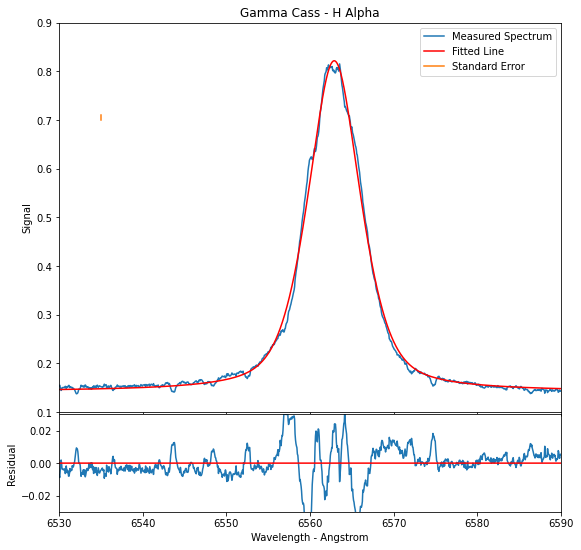

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [4, 1]})
fig.subplots_adjust(hspace=0.01)
plt.rcParams["figure.figsize"]=(12,9)

#

ax1.plot(x[Ha],Ycass_ExtCorr[Ha], label="Measured Spectrum")
ax1.plot(x_array_ha, (lorentzian(x_array_ha, *Ha_l1)+gaussian(x_array_ha,*Ha_fit))/2, 'r-', label="Fitted Line")
ax1.plot([6535,6535], [0.7,0.71], label="Standard Error")
ax1.set_title("Gamma Cass - H Alpha")
ax1.set_ylabel("Signal")
ax1.set_xlabel("Wavelength - Angstrom")
ax1.set_ylim([0.1,0.9])
ax1.set_xlim([6530,6590])
ax1.legend()

ax2.plot(x[Ha], (lorentzian(x[Ha], *Ha_l1)+gaussian(x[Ha],*Ha_fit))/2- Ycass_ExtCorr[Ha] , label="Residual")
ax2.plot(x[Ha], x[Ha] - x[Ha], 'r', label="Fit")
ax2.set_xlabel("Wavelength - Angstrom")
ax2.set_ylabel("Residual")
ax2.set_ylim([-0.03,0.03])
ax2.set_xlim([6530,6590])


(4850.0, 4870.0)

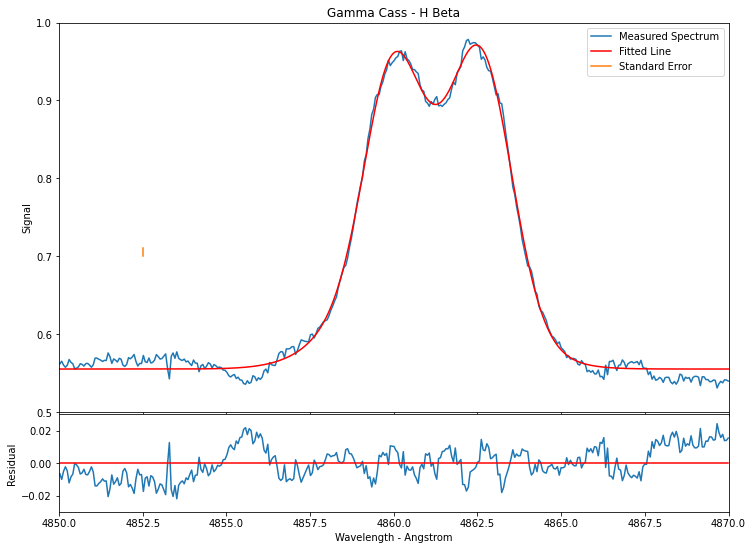

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [4, 1]})
fig.subplots_adjust(hspace=0.01)
plt.rcParams["figure.figsize"]=(9,9)


ax1.plot(x[Hb],Ycass_ExtCorr[Hb], label="Measured Spectrum")
ax1.plot(x_array_hb, double(x_array_hb, *Hb_fit), 'r-', label="Fitted Line")
ax1.plot([4852.5,4852.5], [0.7,0.71], label="Standard Error")
ax1.set_title("Gamma Cass - H Beta")
ax1.set_ylabel("Signal")
ax1.set_xlabel("Wavelength - Angstrom")
ax1.set_ylim([0.5,1])
ax1.set_xlim([4850,4870])
ax1.legend()

ax2.plot(x[Hb], double(x[Hb], *Hb_fit) - Ycass_ExtCorr[Hb] , label="Residual")
ax2.plot(x[Hb], x[Hb] - x[Hb], 'r', label="Fit")
ax2.set_xlabel("Wavelength - Angstrom")
ax2.set_ylabel("Residual")
ax2.set_ylim([-0.03,0.03])
ax2.set_xlim([4850,4870])



In [45]:
print(Ha_fit)

[1.58351918e-01 6.41629959e-01 6.56289712e+03 3.32084145e+00]


In [46]:
print(Hb_fit)

[ 5.80098163e-01  9.57049781e-01  2.18609880e-01  4.86092477e+03
  1.78436902e+00  2.91089636e-01  4.86268476e+03  8.85380650e-01
 -2.88248687e-01  4.85986487e+03  8.12732292e-01]


In [47]:
print(Ha_l1)

[1.26023678e-01 7.17025490e-01 6.56288220e+03 3.49209975e+00]
